In [1]:
!pip install gym[all]
!pip install -U gym[atari,accept-rom-license]
!AutoROM --accept-license
!pip install stable_baselines3
!pip install gymnasium[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.8 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached libtorrent-2.0.7-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827655 sha256=0a5ee449de50760cbd664dda5cc581e547b4927d6bec6ebb22e2d9d535f25740
  Stored in directory: /root/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.4-py3-none-any.whl size=441148 s

In [71]:
import gym
import math
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#RLStuff 
https://github.com/chengxi600/RLStuff/blob/master/Q%20Learning/Atari_DQN.ipynb

In [3]:
import numpy as np
import cv2
import gymnasium
import matplotlib.pyplot as plt
import stable_baselines3.common.atari_wrappers as atari_wrappers

from torch.autograd import Variable
from tqdm import tqdm_notebook

/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [4]:
#Initialize environment. v4 means no action repeat
np.random.seed(0)
env = gymnasium.make("PongNoFrameskip-v4", render_mode='rgb_array')
env = gymnasium.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, 
                                      screen_size=84, terminal_on_life_loss=False, 
                                      grayscale_obs=True, grayscale_newaxis=False, scale_obs=False)

env = gymnasium.wrappers.FrameStack(env, 4)
print(env.observation_space)
obs, _=env.reset(seed=42)

Box(0, 255, (4, 84, 84), uint8)


hyperparameters

In [73]:
#number of frames to run
NUM_FRAMES = 1000000

#number of episodes to run
NUM_EPISODES = 50


#max iterations per run /for one episode
MAX_ITERATIONS = 1000000

MAX_EPISODE = 100000  # Max episode

#epsilon for choosing action
eps = 1

#minimum eps
eps_min = 0.1

#eps linear decay for first 10% of run
eps_linear_decay = (eps-eps_min)/(NUM_FRAMES/5)

#discount factor for future utility
discount_factor = 0.99

#batch size for exp replay
batch_size = 32


#max memory stored for exp replay
MAX_MEMORY = int(NUM_FRAMES/10)

#initial population of memory using random policy
INIT_MEMORY = int(NUM_FRAMES/20)

#update interval to use target network
TARGET_C = int(NUM_FRAMES/1000)

render_game_window= False

#model mode
SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "/content/model/"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = True  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = False  # Load model from file
LOAD_FILE_EPISODE = 0  # Load Xth episode from file


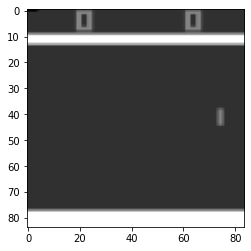

In [6]:
plt.imshow(obs[3] ,cmap='gray')

In [7]:
def cropResult(obs, exclude=(30, -4, -12, 4)):
  output=84
  newobs= np.zeros((4, 84,84))
  for i in range(len(obs)):
    cropped_image= obs[i][exclude[0]:exclude[2], exclude[3]:exclude[1]]
    normalized_image  = np.ascontiguousarray(cropped_image , dtype=np.float32) / 255
    newobs[i]  = cv2.resize(normalized_image, (output,output), interpolation = cv2.INTER_AREA)
  return newobs

In [8]:
# #prepare states
# print(obs)
# newobs= cropResult(obs)
# print(newobs.shape)
# nnew= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0)
# nnew

In [9]:
def plot_obs(obs):
  plt.figure(1, figsize=(20, 10))
  for i in range(len(obs)):
    plt.subplot(1,5,i+1)
    plt.imshow(obs[i], cmap='gray')
  plt.show()

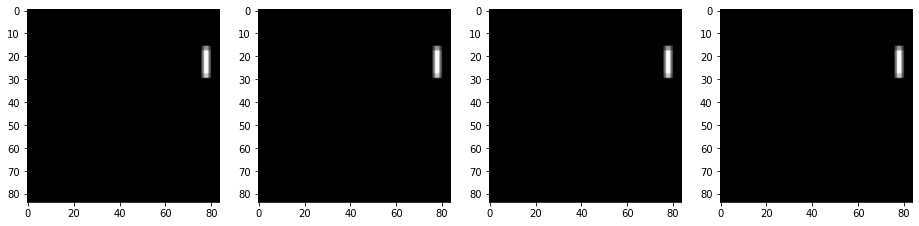

In [10]:
new_obs=cropResult(obs)
#showing how our state looks like
plot_obs(new_obs)


Random startegy

In [11]:
#keep scores
scores = []
#the following line just to see the game since we can't render
renders=[]
frames = 0

#iterate through 10 playthroughs
for _ in tqdm_notebook(range(1)):
    
    #reset env
    env.reset(seed=42)
    done = False
    score = 0
    
    #while game is not over
    while not done:
        #render env
        renders.append(env.render())
        frames += 1
        
        #execute random action
        obs, reward, done, _,_ = env.step(env.action_space.sample())
        
        #track score
        score += reward
        
    #append to score list
    scores.append(score)
env.close()


<ipython-input-11-6fa36c810b57>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1)):


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:357: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


**DQN with torch** 
http://seba1511.net/tutorials/intermediate/reinforcement_q_learning.html

Helper functions:
*  epsilon_greedy
*  plot_durations #this needs updating 



In [12]:
#exploit vs explore
def epsilon_greedy(eps, model, env, state):
  """
  inputs:
  eps: epsilon hyperparameter is a threshold 
  model:is our defined model
  env: our gymnasium environment 
  state: the current state
  outputs:
  int: the best action.
  """
  #explor if random number is less than threshold epsilon
  if np.random.random() < eps:
    action= np.random.randint(0,  env.action_space.n)
  else:
    with torch.no_grad():
      q_values= model(Variable(state))
      #get action witht the highest q_value
      action= np.argmax(Tensor.cpu(q_values))
  return action


In [ ]:
#update this function to plot scores instead of durations
# episode_durations = []

# def plot_durations():
#   plt.figure(2)
#   plt.clf()
#   durations_t = torch.FloatTensor(episode_durations)
#   plt.title('Training...')
#   plt.xlabel('Episode')
#   plt.ylabel('Duration')
#   plt.plot(durations_t.numpy())
#   # Take 100 episode averages and plot them too
#   if len(durations_t) >= 100:
#       means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#       means = torch.cat((torch.zeros(99), means))
#       plt.plot(means.numpy())

#   plt.pause(0.001)  # pause a bit so that plots are updated
#   if is_ipython:
#       display.clear_output(wait=True)
#       display.display(plt.gcf())

In [13]:
#helper block can be used to create function prepare state
#new_obs is after crop and norm 
print(new_obs.shape)
#print(obs)
pre_tensor= torch.from_numpy(new_obs).float().permute(0,1,2).unsqueeze(dim=0)
print(pre_tensor.shape)



(4, 84, 84)
torch.Size([1, 4, 84, 84])


In [ ]:
# #helper block to create the model
# obs, _=env.reset(seed=42)
# newobs= cropResult(obs)
# x= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0).to(device)
# print(x.shape)
# conv1= nn.Conv2d(4, 16, kernel_size=8, stride= 4).to(device)
# x= conv1(x)
# print(x.shape)
# r= nn.ReLU().to(device)
# x= r(x)
# print(x.shape)
# conv2= nn.Conv2d(16, 32, kernel_size=4, stride= 2).to(device)
# x= conv2(x)
# print(x.shape)
# x= r(x)
# f = nn.Flatten().to(device)
# x= f(x)
# print(x.shape)
# l1= nn.Linear(2592, 256).to(device)
# x= l1(x)
# print(x.shape)
# x= r(x)
# l2= nn.Linear(256, env.action_space.n).to(device)
# y= l2(x)
# print(y.shape)

In [14]:
class DQN (nn.Module):
  def __init__(self):
    super(DQN, self).__init__()
    self.ch_in= 4
    self.conv1_ch= 16
    self.conv2_ch=32
    self.linear1_in= 2592
    self.linear2_in= 256
    self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(8,8), stride=4) 
    self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(4,4),stride=2)
    self.flatten= nn.Flatten()
    self.linear1= nn.Linear(self.linear1_in, self.linear2_in)
    self.linear2= nn.Linear(self.linear2_in, env.action_space.n)
    self.rel= nn.ReLU()
  def forward(self, x):
    x= self.rel(self.conv1(x))
    x= self.rel(self.conv2(x))
    x= self.flatten(x)
    x= self.rel(self.linear1(x))
    output= self.linear2(x)
    return output  

#initialize the model
model = DQN()
model.to(device)

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2592, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=6, bias=True)
  (rel): ReLU()
)

In [ ]:
#helper block to check if the model is working
obs, _=env.reset(seed=42)
newobs= cropResult(obs)
state= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0).to(device)
#print(type((Variable(state).type(FloatTensor)).to(device)))
#model(state)
#helper block to check epsilon greedy
# with torch.no_grad():
#   q_values= model(Variable(state))
#   #get action witht the highest q_value
#   action= np.argmax(Tensor.cpu(q_values))
#action= epsilon_greedy(0.2, model, env, state)

tensor(0)


#The training Loop

In [ ]:
# #firsat defining the replay memory
# Transition = namedtuple('Transition',
#                         ('state', 'action', 'next_state', 'reward'))


# class ReplayMemory(object):

#     def __init__(self, capacity):
#         self.capacity = capacity
#         self.memory = []
#         self.position = 0

#     def push(self, *args):
#         """Saves a transition."""
#         if len(self.memory) < self.capacity:
#             self.memory.append(None)
#         self.memory[self.position] = Transition(*args)
#         self.position = (self.position + 1) % self.capacity

#     def sample(self, batch_size):
#         return random.sample(self.memory, batch_size)

#     def __len__(self):
#         return len(self.memory)

In [15]:
#define the modle first and the optimizer, and the replay memory
# model = DQN()
# model= model.to(device)
target_model= DQN()
target_model.to(device)

target_model.load_state_dict(model.state_dict())
target_model.eval()


optimizer = optim.RMSprop(model.parameters())
#self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha) to try another optimizer
#memory = ReplayMemory(10000)

In [ ]:
# #optimize model is the function that will perform a single step of the optimization:
# # - samples a batch
# # - concatnate the tensores into a single one 
# # - compute Q(s(t),a(t)) and V(s(t+1)) = max(Q(s(t+1), a))
# # - combine the previous two into our loss "Huber loss"
# last_sync= 0
# def optimize_model():
#   global last_sync
#   #if memory is less than batch size we are still in the early steps and we don't do any thing
#   if len(memory)< batch_size:
#     return 
#   transitions= memory.sample(batch_size)
#   #Transpose the batch 
#   batch= Transition(*zip(*transitions))

#   #Compute a mask of non_final satets and concatenate the batch elements
#   non_final_mask= ByteTensor(tuple(map(lambda s:s is not None, batch.next_state)))

#   # We don't want to backprop through the expected action values and volatile
#   # will save us on temporarily changing the model parameters'
#   # requires_grad to False!
#   non_final_next_states= Variable(torch.cat([s for s in batch.next_state if s is not None]), volatile= True)
#   state_batch= Variable(torch.cat(batch.state))
#   action_batch= Variable(torch.cat(batch.action))
#   reward_batch = Variable(torch.cat(batch.reward))

#   # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
#   # columns of actions taken
#   state_action_values= model(state_batch).gather(1, action_batch)
#   # Compute V(s_{t+1}) for all next states.
#   next_state_values = Variable(torch.zeros(batch_size).type(Tensor))
#   next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
#   # Now, we don't want to mess up the loss with a volatile flag, so let's
#   # clear it. After this, we'll just end up with a Variable that has
#   # requires_grad=False
#   next_state_values.volatile = False
#   # Compute the expected Q values
#   expected_state_action_values = (next_state_values * discount_factor) + reward_batch

#   # Compute Huber loss
#   loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

#   # Optimize the model
#   optimizer.zero_grad()
#   loss.backward()
#   for param in model.parameters():
#       param.grad.data.clamp_(-1, 1)
#   optimizer.step()


In [ ]:
env.reset()

(<gymnasium.wrappers.frame_stack.LazyFrames at 0x7ff5f4a5a810>,
 {'lives': 0, 'episode_frame_number': 29, 'frame_number': 40})

experince replay: from the post https://medium.com/nerd-for-tech/reinforcement-learning-deep-q-learning-with-atari-games-63f5242440b1
it is used to create one network (targetNetwork) to generate Q values and another one (onlineNetwork) to train and basically the targetNetwork is taken by coping the onlineNetwork every C steps...
this means more stabality.


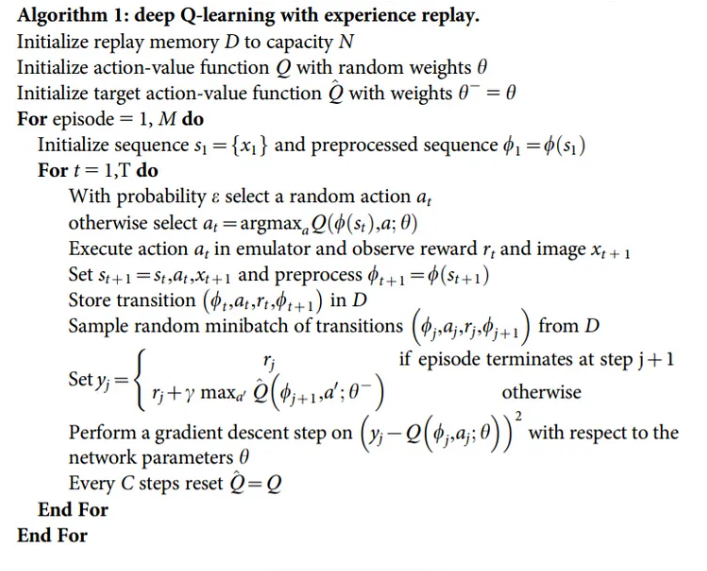

In [95]:
#Prefill memory with INIT_MEMORY frames

#init memory using deque to only store MAX_MEMORY
memory = deque(maxlen=MAX_MEMORY)

#progress bar
pbar = tqdm_notebook(total=INIT_MEMORY)

#playthrough game until memory is prefilled
while len(memory) < INIT_MEMORY:
    
    #reset env
    obs, _=env.reset(seed=42)
    newobs= cropResult(obs)
    state= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0)


    done = False
    
    #playthrough
    while not done:
        
        #random action
        action = env.action_space.sample()
        
        #execute action
        new_state, reward, done,_, info = env.step(action)
        newobs= cropResult(new_state)
        next_state= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0)
        # reward= Tensor([reward])
        # action = Tensor([action])
        # done= Tensor([done])
 
        #add transition to memory
        memory.append([state, action, reward, next_state, done])
        
        #progress bar
        pbar.update(1)
        
        #update state
        state = next_state
        
#close progress bar
pbar.close()



<ipython-input-95-732858c6e67b>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=INIT_MEMORY)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [97]:
def experince_replay (memory, model, target_model, discount_factor, batch_size):
  """
  inputs:
  memory: array of environment transactions looks like [state, action, reward, new_state, done] 
  model: the onlineNetwork "to be trained"
  target_model: the targetNetwork "to get the Q-values"
  discount_factor: discount factor for future utility
  batch_size: size of minibatch
  output:
  none "this function is used to update the targetNetwork"
  """
  if len(memory)< batch_size:
    loss, max_q= [0,0]
    #return loss, max_q
    return loss, max_q

  states= []
  targets=[]
  #sample a random mini batch from the memory of size "batch_size"
  state, action, reward, new_state, done= zip(*random.sample(memory, batch_size))

  # Concat batches in one array
  # (np.arr, np.arr) ==> np.BIGarr
  state = np.concatenate(state)
  next_state = np.concatenate(new_state)
  # #update actions to be int instead of float
  # action_list = list(action)
  # typecst= [a.type(torch.int64) for a in action_list]
  # action= tuple(typecst)

  # send them to device
  state = torch.tensor(state, dtype=torch.float, device=device)
  next_state = torch.tensor(next_state, dtype=torch.float, device=device)
  action = torch.tensor(action, dtype=torch.long, device=device)
  reward = torch.tensor(reward, dtype=torch.float, device=device)
  done = torch.tensor(done, dtype=torch.float, device=device)

  #Make the predictions
  state_q_values = model(state)
  next_states_q_values = model(next_state)
  next_states_target_q_values = target_model(next_state)

  # Find selected action's q_value
  selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)

  # Get indice of the max value of next_states_q_values
  # Use that indice to get a q_value from next_states_target_q_values
  # We use greedy for policy So it called off-policy
  next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
  # Use Bellman function to find expected q value
  expected_q_value = reward + discount_factor * next_states_target_q_value * (1 - done)
  # Calc loss with expected_q_value and q_value
  loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, torch.max(state_q_values).item()

In [96]:
#helper block for the experince replay

if len(memory)< batch_size:
    loss, max_q= [0,0]
    #return loss, max_q
    print(loss, max_q)

states= []
targets=[]
#sample a random mini batch from the memory of size "batch_size"
state, action, reward, new_state, done= zip(*random.sample(memory, batch_size))

# Concat batches in one array
# (np.arr, np.arr) ==> np.BIGarr
state = np.concatenate(state)
next_state = np.concatenate(new_state)
#update actions to be int instead of float
# action_list = list(action)
# typecst= [a.type(torch.int64) for a in action_list]
# action= tuple(typecst)

# send them to device
state = torch.tensor(state, dtype=torch.float, device=device)
next_state = torch.tensor(next_state, dtype=torch.float, device=device)
action = torch.tensor(action, dtype=torch.long, device=device)
reward = torch.tensor(reward, dtype=torch.float, device=device)
done = torch.tensor(done, dtype=torch.float, device=device)

#Make the predictions
state_q_values = model(state)
next_states_q_values = model(next_state)
next_states_target_q_values = target_model(next_state)

# Find selected action's q_value
selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)

# Get indice of the max value of next_states_q_values
# Use that indice to get a q_value from next_states_target_q_values
# We use greedy for policy So it called off-policy
next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
# Use Bellman function to find expected q value
expected_q_value = reward + discount_factor * next_states_target_q_value * (1 - done)
# Calc loss with expected_q_value and q_value
loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

optimizer.zero_grad()
loss.backward()
optimizer.step()
print(loss, torch.max(state_q_values).item())



tensor(0.0391, device='cuda:0', grad_fn=<MeanBackward0>) 0.1606796383857727


you are working here for the training loop

In [ ]:
pbar = tqdm_notebook(total=50)
startEpisode=1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
total_step = 1  # Cumulkative sum of all steps in episodes
for episode in range(startEpisode,MAX_EPISODE):
  startTime= time.time() #stor the time

  #prepare state
  obs, _=env.reset(seed=42)
  newobs= cropResult(obs)
  state= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0)
  
  total_max_q_val= 0 #the total max q value
  total_reward= 0 # reward for each episode
  total_loss= 0 #loss for each episode

  for frame in range(MAX_ITERATIONS):

    if render_game_window:
      #we can store renders like before
      env.render()
    # Select and perform an action using epsilon greedy algo
    action = epsilon_greedy(eps, model, env, state.to(device))

    #execute the action
    obs, reward, done, _,_ = env.step(action)

    #prepare next state
    newobs= cropResult(obs)
    next_state= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0)

    #add transition to memory
    #memory.append([state, Tensor([action]), Tensor([reward]), next_state, Tensor([done])])
    memory.append([state, action, reward, next_state, done])

    #move to the next state
    state= next_state

    if TRAIN_MODEL:
      # Perform one step of the optimization (on the target network)
      loss, max_q_val = experince_replay (memory, model, target_model, discount_factor, batch_size)  # Train with random batch_size from memory
    else:
      loss, max_q_val= [0,0]

    total_loss+= loss
    total_max_q_val += max_q_val
    total_reward += reward
    total_step +=1

    #decay epsilon
    eps -= eps_linear_decay
    eps = max(eps, eps_min)

    if done:  # Episode completed
      currentTime = time.time()  # Keep current time
      time_passed = currentTime - startTime  # Find episode duration
      current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
      epsilonDict = {'epsilon': eps}  # Create epsilon dict to save model as file


      if TRAIN_MODEL:
          target_model.load_state_dict(model.state_dict())  # Update target model
      
      last_100_ep_reward.append(total_reward)
      avg_max_q_val = total_max_q_val / frame

      outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
              episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, eps, time_passed, frame, total_step
      )

      print(outStr)

      break
    pbar.update(1) 
  pbar.close()


<ipython-input-99-e76c62ff9b5f>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=50)


  0%|          | 0/50 [00:00<?, ?it/s]

Episode:1 Time:17:55:34 Reward:-20.00 Loss:24.53 Last_100_Avg_Rew:-20.000 Avg_Max_Q:-0.013 Epsilon:0.99 Duration:8.63 Step:1000 CStep:1002
Episode:2 Time:17:55:42 Reward:-20.00 Loss:23.79 Last_100_Avg_Rew:-20.000 Avg_Max_Q:-0.068 Epsilon:0.99 Duration:8.01 Step:979 CStep:1982
Episode:3 Time:17:55:49 Reward:-21.00 Loss:21.17 Last_100_Avg_Rew:-20.333 Avg_Max_Q:-0.130 Epsilon:0.98 Duration:7.03 Step:851 CStep:2834
Episode:4 Time:17:55:56 Reward:-20.00 Loss:19.94 Last_100_Avg_Rew:-20.250 Avg_Max_Q:-0.159 Epsilon:0.98 Duration:6.89 Step:834 CStep:3669
Episode:5 Time:17:56:05 Reward:-18.00 Loss:24.89 Last_100_Avg_Rew:-19.800 Avg_Max_Q:-0.200 Epsilon:0.97 Duration:9.14 Step:1113 CStep:4783
Episode:6 Time:17:56:11 Reward:-21.00 Loss:18.08 Last_100_Avg_Rew:-20.000 Avg_Max_Q:-0.218 Epsilon:0.97 Duration:6.31 Step:761 CStep:5545
Episode:7 Time:17:56:19 Reward:-21.00 Loss:21.51 Last_100_Avg_Rew:-20.143 Avg_Max_Q:-0.227 Epsilon:0.97 Duration:7.55 Step:909 CStep:6455
Episode:8 Time:17:56:27 Reward:-

In [ ]:
# #first attempt of traning loop
# #init scores
# scores = []

# #init total_frames
# total_frames = 0

# #init num_updates
# num_updates = 0

# #init fitness history
# fit_hist = {'loss': []}

# pbar = tqdm_notebook(total=50)

# #run frames
# while total_frames < NUM_FRAMES:
#     # Initialize the environment and state
#     obs, _=env.reset(seed=42)
#     newobs= cropResult(obs)
#     state= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0)
#     done= False
#     score= 0
#     frames= 0
#     #playing through this round
#     for frame in range(MAX_ITERATIONS):
#         frames+=1

#         # Select and perform an action using epsilon greedy algo
#         action = epsilon_greedy(eps, model, env, state)

#         #execute the action
#         obs, reward, done, _,_ = env.step(action)
#         #track score
#         score+=reward

#         # reward = Tensor([reward])


#         # Observe new state

#         if not done:
#             newobs= cropResult(obs)
#             next_state= torch.from_numpy(newobs).float().permute(0,1,2).unsqueeze(dim=0)
 
#         else:
#             next_state = None

#         # Store the transition in memory
#         memory.push(state, action, next_state, reward)

#         # Move to the next state
#         state = next_state

#         # Perform one step of the optimization (on the target network)
#         optimize_model()

#         #decay epsilon
#         eps -= eps_linear_decay
#         eps = max(eps, eps_min)

#         if done:
#             break

#     scores.append(score)
#     total_frames += frames
#     pbar.update(1)    

# pbar.close()


<ipython-input-71-d282d204cdef>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=50)


  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: ignored